In [1]:
import pandas as pd
import numpy as np
import gzip
import re
from string import punctuation
import time
from nltk import tokenize
from nltk.stem import PorterStemmer
import gensim
from nltk.corpus import stopwords
from collections import Counter
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.test.utils import datapath
from gensim import similarities

## Modelagem de Assuntos
1. Usando a biblioteca Gensim, treine um modelo LSI e LDA para o seu corpus propondo uma metodologia para otimizaçao do numero de assuntos

Lendo a base de dados

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient = 'index')

df = getDF('reviews_Video_Games_5.json.gz')

Tokenizando o texto, colocando em caixa baixa, removendo stop words, termos de um caracter e termos que apareceram menos do que 20 vezes.

In [3]:
textos = list(df['reviewText'])

sw = stopwords.words('english') + list(punctuation) + ["..", "...", "....", "....."]

textos_limpos = []
c = Counter([])
for texto in textos:
    tlimpo = [token.lower() for token in tokenize.TweetTokenizer().tokenize(texto) if token.lower() not in sw]
    c.update(tlimpo)
    textos_limpos.append(tlimpo)

ps = PorterStemmer()
stemmed = []
for t in textos_limpos:
    txt = [ps.stem(token) for token in t]
    stemmed.append(txt)
stemmed = [[token for token in t if (c[token] >= 1000 and len(token) > 1)] for t in stemmed]

dicionario = corpora.Dictionary(stemmed)

corpus = [dicionario.doc2bow(d) for d in stemmed]

Ajustando vários modelos lsi e lda e verificando a medida de coerência deles.

In [4]:
start_time = time.time()
lsi = []
lda = []
co_lsi = []
co_lda = []
for i in range(2, 16): 
    print(i)
    tmp_lsi = models.LsiModel(corpus, id2word = dicionario, num_topics = i)
    coherencemodel = CoherenceModel(model = tmp_lsi, texts = textos_limpos, dictionary = dicionario, coherence = 'c_v')
    lsi.append(tmp_lsi)
    co_lsi.append(coherencemodel.get_coherence())
    tmp_lda = models.LdaModel(corpus, id2word = dicionario, num_topics = i)
    coherencemodel = CoherenceModel(model = tmp_lda, texts = textos_limpos, dictionary = dicionario, coherence = 'c_v')
    lda.append(tmp_lda)
    co_lda.append(coherencemodel.get_coherence())
end_time = time.time()
end_time - start_time

2
3
4
5
6
7
8
9
10
11
12
13
14
15


8094.802251577377

Selecionando um número adequado de tópicos

In [5]:
co_lsi

[0.2529319538961585,
 0.3029128593252401,
 0.2965119059655144,
 0.2924433849299744,
 0.2998660412744665,
 0.3084074529740683,
 0.3210406929981887,
 0.31468607952253896,
 0.3031314751404356,
 0.3093821418786243,
 0.30305609479852286,
 0.3048400329716114,
 0.2997575126542965,
 0.294198579433403]

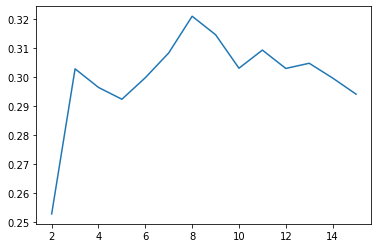

In [6]:
plt.plot(list(range(2,16)), co_lsi)

In [7]:
co_lda

[0.26142765870172135,
 0.2767811783253773,
 0.2759851069651817,
 0.29262218625880265,
 0.2869823313882864,
 0.2955920149172305,
 0.2965274890326185,
 0.3159551043701472,
 0.3057630042594076,
 0.31528258133756903,
 0.31852158090184035,
 0.32613648247003313,
 0.3244953996734539,
 0.31708924834036745]

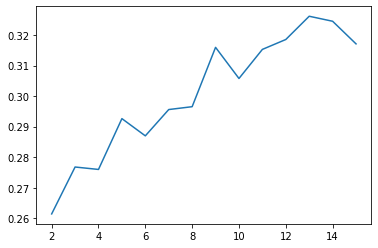

In [8]:
plt.plot(list(range(2,16)), co_lda)

In [9]:
best_lsi = lsi[6]
best_lda = lda[11]

best_lsi.save("lsi")
best_lda.save("lda")

In [10]:
best_lsi.print_topics()

[(0,
  '0.755*"game" + 0.215*"play" + 0.189*"like" + 0.167*"get" + 0.155*"one" + 0.134*"time" + 0.097*"use" + 0.096*"make" + 0.087*"good" + 0.086*"also"'),
 (1,
  '-0.615*"game" + 0.266*"get" + 0.234*"like" + 0.209*"one" + 0.204*"use" + 0.162*"time" + 0.119*"go" + 0.117*"make" + 0.116*"also" + 0.113*"..."'),
 (2,
  '0.874*"play" + -0.150*"game" + 0.132*"player" + 0.117*"mode" + 0.097*"fun" + 0.089*"wii" + 0.072*"..." + -0.072*"weapon" + 0.066*"xbox" + -0.065*"one"'),
 (3,
  '0.874*"..." + -0.157*"use" + -0.148*"mario" + -0.146*"control" + 0.132*".." + 0.113*"like" + -0.102*"level" + -0.101*"wii" + -0.100*"also" + -0.100*"player"'),
 (4,
  '-0.439*"control" + 0.291*"level" + -0.270*"wii" + 0.229*"get" + -0.207*"xbox" + -0.187*"like" + -0.185*"use" + 0.184*"play" + 0.171*"time" + -0.157*"ps3"'),
 (5,
  '-0.501*"like" + 0.483*"mario" + 0.339*"..." + 0.250*"level" + 0.243*"super" + 0.183*"wii" + 0.138*"nintendo" + 0.119*"time" + 0.115*"new" + 0.109*"one"'),
 (6,
  '-0.501*"like" + 0.443*"g

In [11]:
best_lda.print_topics()

[(0,
  '0.058*"control" + 0.050*"xbox" + 0.040*"use" + 0.024*"button" + 0.024*"360" + 0.022*"ps3" + 0.021*"headset" + 0.018*"sound" + 0.017*"one" + 0.015*"work"'),
 (1,
  '0.034*"game" + 0.018*"world" + 0.014*"like" + 0.013*"quest" + 0.011*"time" + 0.011*"get" + 0.011*"one" + 0.010*"rpg" + 0.010*"item" + 0.010*"level"'),
 (2,
  '0.069*"game" + 0.021*"level" + 0.017*"get" + 0.016*"time" + 0.014*"like" + 0.012*"one" + 0.010*"play" + 0.010*"fun" + 0.009*"also" + 0.009*"fight"'),
 (3,
  '0.256*"..." + 0.058*".." + 0.023*"like" + 0.019*"game" + 0.018*"get" + 0.014*"dont" + 0.013*"say" + 0.011*"know" + 0.011*"go" + 0.010*"bad"'),
 (4,
  '0.041*"game" + 0.039*"car" + 0.038*"race" + 0.030*"mission" + 0.028*"drive" + 0.018*"creed" + 0.018*"like" + 0.015*"sonic" + 0.013*"gta" + 0.013*"track"'),
 (5,
  '0.041*"game" + 0.021*"weapon" + 0.020*"like" + 0.017*"kill" + 0.015*"get" + 0.014*"gun" + 0.013*"shoot" + 0.013*"mission" + 0.012*"shooter" + 0.011*"play"'),
 (6,
  '0.030*"campaign" + 0.028*"map"

<hr>

2. Construa Uma matriz de similaridade entre os documentos do corpus a partir dos pesos

Consultei: https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html

In [13]:
index = similarities.MatrixSimilarity(best_lda[corpus])

Vendo os documentos mais similares ao primeiro documento

In [17]:
textos[0]

'Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be "unlocked" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don\'t like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I\'m really tired of arcade style rally/racing games anyway.I\'ll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.'

In [18]:
stemmed[0]

['game',
 'game',
 'window',
 'live',
 'bug',
 'race',
 'car',
 'unlock',
 'buy',
 'game',
 'paid',
 '30',
 'dollar',
 'game',
 'new',
 'like',
 'idea',
 'keep',
 'pay',
 'keep',
 'play',
 'graphic',
 'dirt',
 'never',
 'buy',
 'game',
 "i'm",
 'style',
 'race',
 'game',
 'anyway',
 "i'll",
 'get',
 'fix',
 'burn',
 ':)',
 'read',
 'review',
 'enjoy',
 'sure',
 'rate',
 'help']

In [20]:
vec_bow = dicionario.doc2bow(stemmed[0])
vec_lda = best_lda[vec_bow] 
print(vec_lda)

[(4, 0.18997198), (8, 0.32742816), (9, 0.26120427), (10, 0.20529364)]


In [32]:
sims = index[vec_lda]
sims = sorted(enumerate(sims), key=lambda item: -item[1])[0:5]
for i, s in enumerate(sims):
    print(s, textos[i])
    print()

(0, 1.0) Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be "unlocked" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.

(105364, 0.9971047) If you like rally cars get this game you will have fun.It is more oriented to &#34;European market&#34; since here in America there isn't a huge rally fan party. Music it is very European an